In [1]:
from ultralytics import YOLO
from PIL import Image
import numpy as np
import cv2
import supervision as sv
import easyocr
reader = easyocr.Reader(['en'], recognizer=False)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [24]:
"""
YOLO-obb-small model trained on synthetic data on Google Colab runtime
"""
model = YOLO("../models/yolo-obb-s-100ep.pt")

In [3]:
def crop_license_plate(img):
    """
    Runs the YOLO model on the input image and crops the license plate

    Returns:
    - Image: the cropped license plate
    """
    results = model(img)

    detections = sv.Detections.from_ultralytics(results[0])
    xyxyxyxy = detections[0].data['xyxyxyxy'][0]

    point1, point2, point3, point4 = xyxyxyxy
    box_points = [point3, point2, point1, point4]

    if box_points[0][0] > box_points[1][0]:
        box_points = [point1, point4, point3, point2]

    # make blank image of size 520x110
    blank_image = np.zeros((110, 520, 3), np.uint8)
    blank_image[:] = (255, 255, 255)

    # warp
    matrix = cv2.getPerspectiveTransform(np.array(box_points, dtype=np.float32), np.array([[0, 0], [520, 0], [520, 110], [0, 110]], dtype=np.float32))
    warped = cv2.warpPerspective(cv2.imread(img), matrix, (520, 110))

    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    warped = Image.fromarray(warped)
    return warped

In [4]:
def detect_text(img):
    """
    Detects text boxes in the input image

    Returns:
    - list: list of bounding boxes of the detected text
    """
    img = np.array(img)
    result = reader.detect(img, add_margin=0, slope_ths=0)[1][0]
    return result

def find_largest_text_area(results):
    """
    Finds the largest text area in the input image

    Returns:
    - list: list of bounding boxes of the largest text area
    """
    max_width = 0
    max_width_box = None
    for box in results:
        width = box[1][0] - box[0][0]
        if width > max_width:
            max_width = width
            max_width_box = box

    return max_width_box

def find_largest_text_area(results):
    """
    Finds the largest text area in the input image

    Returns:
    - list: list of bounding boxes of the largest text area
    """
    max_width = 0
    max_width_box = None
    for box in results:
        width = box[1][0] - box[0][0]
        if width > max_width:
            max_width = width
            max_width_box = box

    return max_width_box

def extract_box(img, result):
    """
    Extracts the bounding box of the detected text

    Returns:
    - Image: the cropped text box
    """
    p1, p2, p3, p4 = result
    box_points = [p1, p2, p3, p4]

    # make blank image of size 520x110
    size = (510, 110)
    blank_image = np.zeros((size[0], size[1], 3), np.uint8)
    blank_image[:] = (255, 255, 255)

    # warp
    matrix = cv2.getPerspectiveTransform(np.array(box_points, dtype=np.float32), np.array([[0, 0], [size[0], 0], [size[0], size[1]], [0, size[1]]], dtype=np.float32))
    warped = cv2.warpPerspective(img, matrix, (size[0], size[1]))

    warped = Image.fromarray(warped)

    return warped


In [5]:
def thresholding(img):
    """
    Applies thresholding to the input image
    """
    img.save("temp.jpg")
    img = cv2.imread("temp.jpg", cv2.IMREAD_GRAYSCALE)

    
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    _, im_gray_th_otsu = cv2.threshold(closing, 128, 192, cv2.THRESH_OTSU)

    _, im_gray_th = cv2.threshold(im_gray_th_otsu, 128, 255, cv2.THRESH_BINARY)

    im_gray_th = cv2.bitwise_not(im_gray_th)

    return Image.fromarray(im_gray_th)


image 1/1 /home/mees/Desktop/UVA/Scriptie/License-Plate-Recognition-Thesis/ALPR/../test_notebooks/images/IMG_2082.jpg: 352x640 479.5ms
Speed: 4.0ms preprocess, 479.5ms inference, 13.4ms postprocess per image at shape (1, 3, 352, 640)


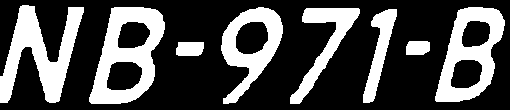

In [6]:
def get_binary_lp_cutout(path_to_img):
    """
    Returns a binary image of the license plate cutout
    """
    cropped = crop_license_plate(path_to_img)
    result = detect_text(cropped)
    result = find_largest_text_area(result)

    return thresholding(extract_box(np.array(cropped), result))

get_binary_lp_cutout("../test_notebooks/images/IMG_2082.jpg")

# CHARACHTER SEGMENATION

In [7]:
img = get_binary_lp_cutout("../test_notebooks/images/4.jpg")



img_bgr = cv2.cvtColor(np.array(img), cv2.COLOR_GRAY2BGR)

import functools
# Find contours and get bounding box for each contour
cnts, _ = cv2.findContours(np.array(img), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boundingBoxes = [cv2.boundingRect(c) for c in cnts]

# Keep 8 largest bounding boxes by area
boundingBoxes = sorted(boundingBoxes, key=lambda x: x[2]*x[3], reverse=True)[:8]

# Sort the bounding boxes from left to right, top to bottom
# sort by Y first, and then sort by X if Ys are similar
def compare(rect1, rect2):
    if abs(rect1[1] - rect2[1]) > 10:
        return rect1[1] - rect2[1]
    else:
        return rect1[0] - rect2[0]
boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare))

# Draw bounding boxes
for box in boundingBoxes:
    x, y, w, h = box
    cv2.rectangle(img_bgr, (x, y), (x+w, y+h), (0, 255, 0), 2)

# save image with bounding boxes
cv2.imwrite("bounding_boxes.jpg", img_bgr)


image 1/1 /home/mees/Desktop/UVA/Scriptie/License-Plate-Recognition-Thesis/ALPR/../test_notebooks/images/4.jpg: 640x480 507.3ms
Speed: 4.6ms preprocess, 507.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


True

In [28]:

def do_character_segmentation(img):
    """
    Does character segmentation on the input image

    Returns:
    - list: list of cropped character images
    - idx: index of the two smallest bounding boxes i.e the two stripes
    """
    img = np.array(img)
    cnts, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    boundingBoxes = sorted(boundingBoxes, key=lambda x: x[2]*x[3], reverse=True)[:8]
    boundingBoxes = sorted(boundingBoxes, key=lambda x: x[0])

    # Get two smallest bounding boxes
    boundingBoxesSmallest = sorted(boundingBoxes, key=lambda x: x[2]*x[3])[:2]
    
    # Get index of the two smallest bounding boxes
    idx1 = boundingBoxes.index(boundingBoxesSmallest[0])
    idx2 = boundingBoxes.index(boundingBoxesSmallest[1])


    characters = []
    for box in boundingBoxes:
        x, y, w, h = box
        characters.append(img[y:y+h, x:x+w])

    return characters, (idx1, idx2)

characters = do_character_segmentation(np.array(get_binary_lp_cutout("../test_notebooks/images/5.jpg")))



image 1/1 /home/mees/Desktop/UVA/Scriptie/License-Plate-Recognition-Thesis/ALPR/../test_notebooks/images/5.jpg: 640x480 547.3ms
Speed: 8.4ms preprocess, 547.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)
2 5


# Test trained OCR model on LP


In [8]:
import keras
import joblib
import pickle
import os
print(os.listdir("."))

2024-05-06 13:38:55.323279: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 13:38:55.323362: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 13:38:55.324527: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['temp.jpg', 'bounding_boxes.jpg', 'full_model.ipynb']


In [11]:
model = '../models/ocr_model.h5'
ocr = keras.models.load_model(model)


for box in boundingBoxes:
    x, y, w, h = box
    cropped = img.crop((x, y, x+w, y+h))
    cropped = cropped.resize((20, 30))

    # create blank black image
    new_img = Image.new("RGB", (23, 33), "black")

    # paste the original image on the blank image in middle
    width, height = cropped.size
    x = 23//2 - width//2
    y = 33//2 - height//2
    new_img.paste(cropped, (x, y))

    new_img = new_img.convert('L')

    img_array = np.array(new_img)
    img_array = img_array / 255.0
    img_array = img_array.astype(int)
    # print(img_array)
    # predict
    img_array = img_array.reshape(1, 33, 23, 1)
    prediction = ocr.predict(img_array, verbose=0)

    lb = pickle.load(open('../test_notebooks/label_encoder.pkl', 'rb'))
    prediction = np.array(prediction)
    # transform the preidctions using the label binarizer
    preds = lb.inverse_transform(prediction.reshape(1, -1))

    print(preds)
    print(prediction)



    



['V']
[[ 3.6563e-12  4.1567e-18  4.8324e-12  9.6413e-22  4.6306e-14  1.2486e-22  4.2687e-16  8.1296e-13  4.5604e-18  1.8956e-06  1.2027e-13  1.3208e-17  9.2463e-12  2.9546e-17  2.3108e-14  1.0859e-17  6.0046e-12  1.4075e-19   6.359e-13  9.1988e-13  1.5436e-06  1.9402e-14   7.881e-13           1  1.1287e-09  1.2375e-12
   1.0426e-21]]
['B']
[[ 2.7338e-05  1.5916e-18  2.3542e-08  9.9239e-06   4.818e-07  0.00036926  3.1393e-10  1.6603e-11  5.7409e-05  7.3145e-06     0.62215  5.4571e-05  8.3484e-11  1.7188e-06     0.37686  4.1663e-10  7.9021e-09  1.1889e-13  3.5038e-07   0.0004586  2.0663e-06  1.9899e-10  6.9033e-14  4.2763e-10  6.9656e-12  2.6339e-13
   1.0423e-09]]
['P']
[[ 0.00016814  1.2044e-18  2.4154e-09  8.0614e-08  7.9143e-11  1.4661e-09  8.5037e-16  1.6119e-10  9.9526e-11  7.3212e-09  0.00029799  2.4037e-08   3.263e-12  4.4385e-11  6.0901e-06  5.9011e-09  3.3777e-14   3.525e-18  2.1582e-08     0.99953  3.3569e-07   9.209e-17  5.6098e-15  4.3072e-11  1.1212e-11  4.6404e-14
   2.306

In [42]:
lb = pickle.load(open('../models/label_encoder.pkl', 'rb'))

def predict_characters(characters, idx):
    """
    Predicts the characters in the input image

    Returns:
    - list: list of predicted characters
    """
    predicted_characters = ['X', 'X', 'X', 'X', 'X', 'X', 'X', 'X']
    for i, char in enumerate(characters):
        if i == idx[0] or i == idx[1]:
            predicted_characters[i] = '-'
            continue

        char = Image.fromarray(char)
        char = char.resize((20, 30))

        new_img = Image.new("RGB", (23, 33), "black")

        width, height = char.size
        x = 23//2 - width//2
        y = 33//2 - height//2

        new_img.paste(char, (x, y))
        new_img = new_img.convert('L')

        img_array = np.array(new_img)
        img_array = img_array / 255.0
        img_array = img_array.astype(int)
        img_array = img_array.reshape(1, 33, 23, 1)

        prediction = ocr.predict(img_array, verbose=0)
        prediction = np.array(prediction)
        preds = lb.inverse_transform(prediction.reshape(1, -1))
        predicted_characters[i] = preds[0]

    predicted_characters = ''.join(predicted_characters)

    return predicted_characters
        
        

predict_characters(characters[0], characters[1])





'80-TR-VL'